## Anomaly Detection: LOF, Isolation Forest

### 1. Import Modules

In [ ]:
# !pip install seaborn

import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
import scipy.io 
import warnings
warnings.filterwarnings('ignore')

### 2. Import Datasets

In [5]:
data = pd.read_csv('loan_data.csv')

data

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
0,22,71948,0,35000,16.02,0.49,3,561,1
1,21,12282,0,1000,11.14,0.08,2,504,0
2,25,12438,3,5500,12.87,0.44,3,635,1
3,23,79753,0,35000,15.23,0.44,2,675,1
4,24,66135,1,35000,14.27,0.53,4,586,1
...,...,...,...,...,...,...,...,...,...
44995,27,47971,6,15000,15.66,0.31,3,645,1
44996,37,65800,17,9000,14.07,0.14,11,621,1
44997,33,56942,7,2771,10.02,0.05,10,668,1
44998,29,33164,4,12000,13.23,0.36,6,604,1


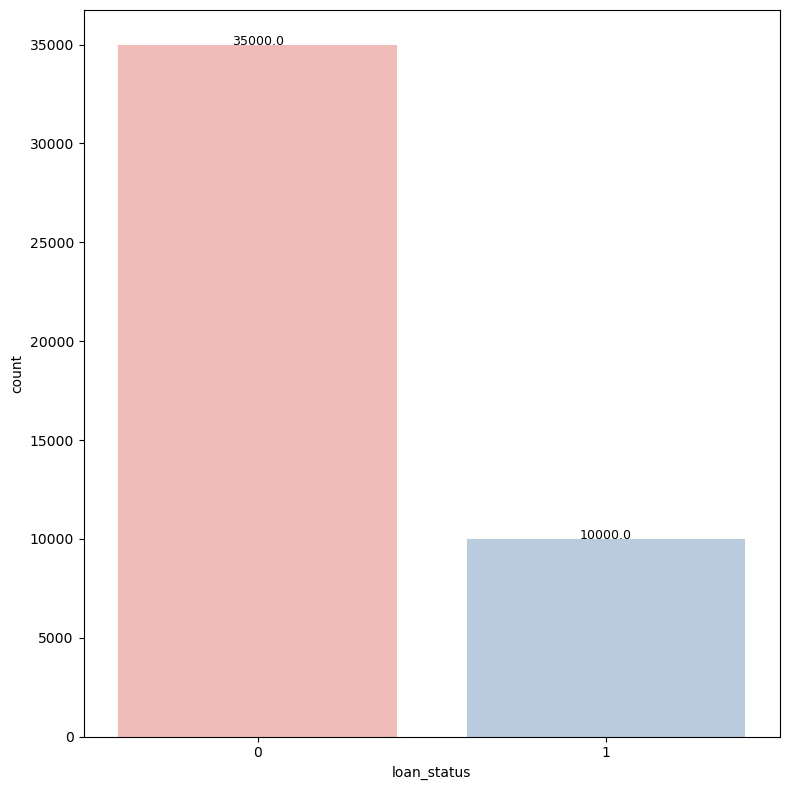

In [6]:
plt.figure(figsize=(8,8))
plt.rcParams['axes.facecolor'] = 'white'
ax= sns.countplot(x='loan_status', data=data, palette='Pastel1')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.tight_layout()

### 3. LOF (Local Outlier Factor)

#### 3-0. Model Evaluation 

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


def return_result(y_true, y_pred):
    performance = {}
    performance['acc'] = accuracy_score(y_true=y_true, y_pred=y_pred, )
    performance['precision_score'] = precision_score(y_true=y_true,y_pred=y_pred, average='macro')
    performance['recall_score'] = recall_score(y_true=y_true,y_pred=y_pred, average='macro')
    performance['f1_score'] = f1_score(y_true=y_true,y_pred=y_pred, average='macro')
    
    return performance

def cf_vis(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cf, annot=True, fmt='d', cmap='Pastel1')
    
    return cf

#### 3-1. LOF From Scratch 

In [8]:
from sklearn.neighbors import NearestNeighbors

def LOF(X, X_test, k):

    knn = NearestNeighbors(n_neighbors=k)

    knn.fit(X)
    
    # Gather the kth nearest neighbor distance
    neighbors_and_distances = knn.kneighbors(X)
    knn_distances = neighbors_and_distances[0]
    neighbors = neighbors_and_distances[1]
    kth_distance = [x[-1] for x in knn_distances] # len(kth_distance)=len(X)
    
    local_reach_density = []
    for i in range(X.shape[0]):
        pt = X[i]
        sum_reachability = 0
        neighbor_distances = knn_distances[i]
        pt_neighbors = neighbors[i]
        for neighbor_distance, neighbor_index in zip(neighbor_distances, pt_neighbors):
            neighbors_kth_distance = kth_distance[neighbor_index]
            sum_reachability = sum_reachability + max([neighbor_distance, neighbors_kth_distance])
            
        avg_reachability = sum_reachability / k
        local_reach_density.append(1/avg_reachability)

    local_reach_density = np.array(local_reach_density) # len(local_reach_density)=len(X)
    lofs = []
    for i in range(X_test.shape[0]):
        pt = X_test[i]
        avg_lrd = np.mean(local_reach_density[neighbors[i]])
        lofs.append(avg_lrd/local_reach_density[i])
        
    return lofs

acc : 0.7395555555555555
precision_score : 0.5036414789058754
recall_score : 0.5013809523809524
f1_score : 0.47888634456940415


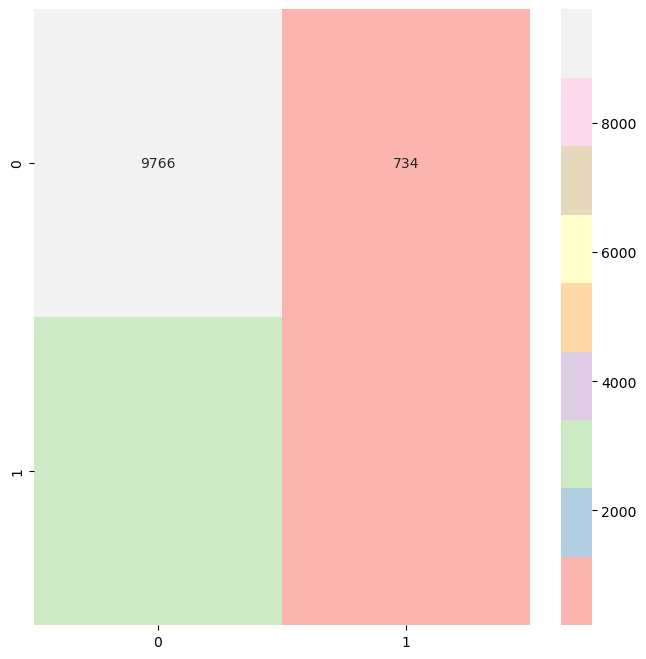

In [29]:
from sklearn.model_selection import train_test_split

def visualize_zoomed_distribution(lof_array):
    plt.figure(figsize=(10, 6))
    plt.hist(lof_array, bins=1000, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Zoomed Distribution of LOF Scores (0.5 to 4)", fontsize=16)
    plt.xlabel("LOF Score", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xlim(0.5, 4)  # x축 범위 제한
    plt.axvline(x=1.5, color='red', linestyle='--', label="Threshold (1.5)")
    plt.legend(fontsize=12)
    plt.grid(alpha=0.01)
    plt.show()



def run_LOF(name):
    data = name
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        
    lof = LOF(X_train, X_test, 20)
    lof = np.array(lof)
    pred = np.where(lof>=1.5,1,0)
    
    performance = return_result(y_test, pred)
    
    cf_vis(y_test, pred)

    for k, v in performance.items():
        print(k, ':', v)
        '''
    # `lof` 배열을 visualize
    lof_array = lof  # run_LOF 함수에서 얻은 LOF 점수 배열
    visualize_zoomed_distribution(lof_array) '''


run_LOF(data)

[k=1]
acc : 0.7777777777777778
precision_score : 0.3888888888888889
recall_score : 0.5
f1_score : 0.43750000000000006
실행 시간: 0.36608초
--------------------
[k=2]
acc : 0.6862962962962963
precision_score : 0.4952557950820164
recall_score : 0.4963095238095238
f1_score : 0.4927517285146387
실행 시간: 0.29552초
--------------------
[k=3]
acc : 0.7094814814814815
precision_score : 0.5032251025582614
recall_score : 0.5020476190476191
f1_score : 0.49431907155273874
실행 시간: 0.29802초
--------------------
[k=4]
acc : 0.7176296296296296
precision_score : 0.5087559540487532
recall_score : 0.5051428571428571
f1_score : 0.49602247327279725
실행 시간: 0.32032초
--------------------
[k=5]
acc : 0.7207407407407408
precision_score : 0.5022053421738346
recall_score : 0.5011904761904762
f1_score : 0.4887450787632933
실행 시간: 0.33199초
--------------------
[k=10]
acc : 0.7284444444444444
precision_score : 0.4986155413786993
recall_score : 0.49935714285714283
f1_score : 0.48196847082443406
실행 시간: 0.39679초
----------------

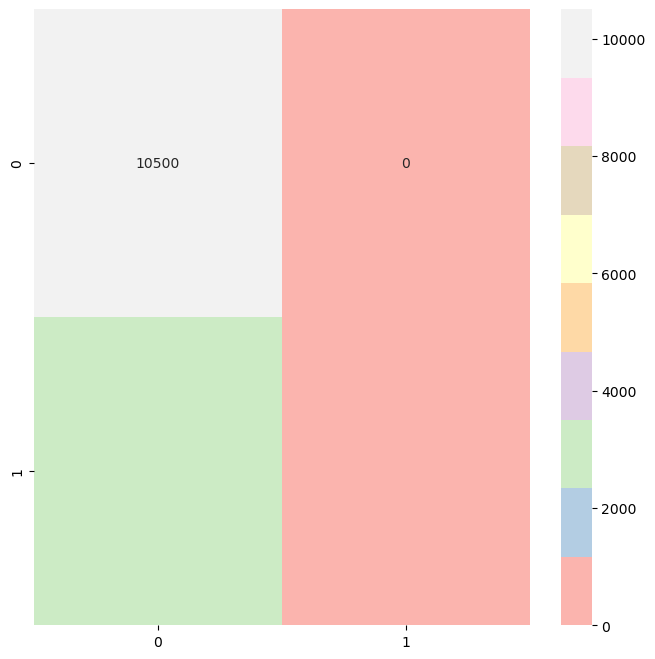

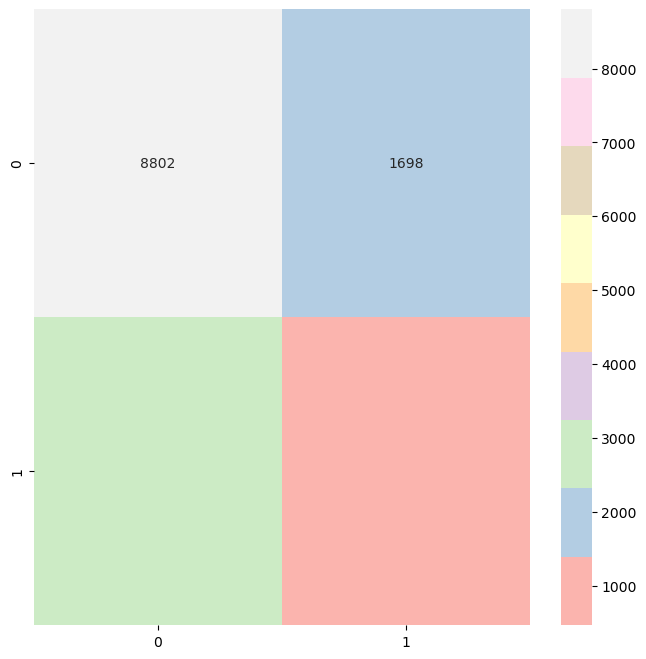

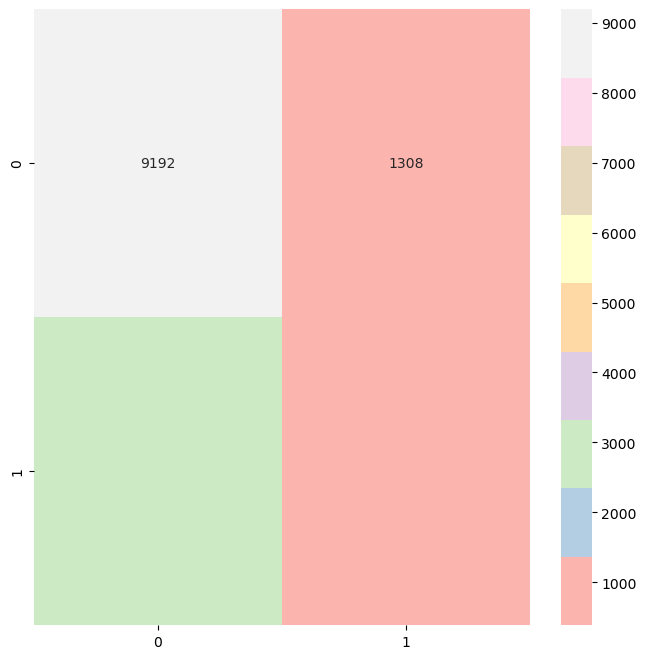

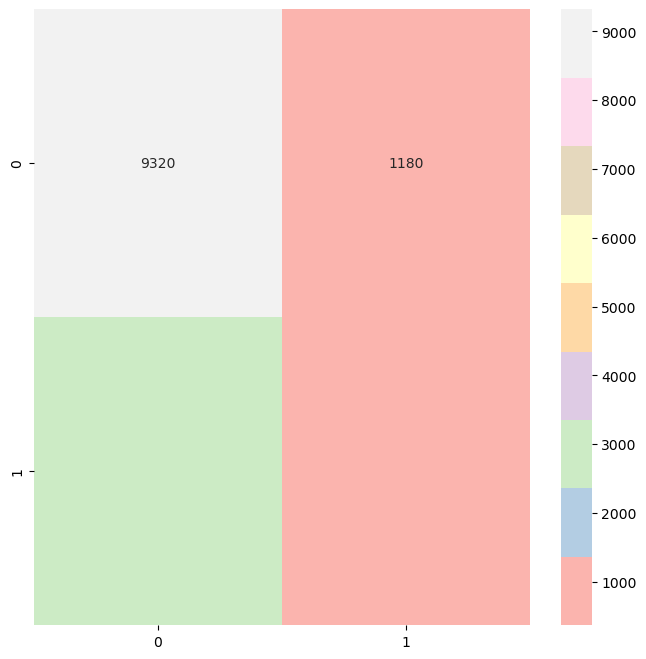

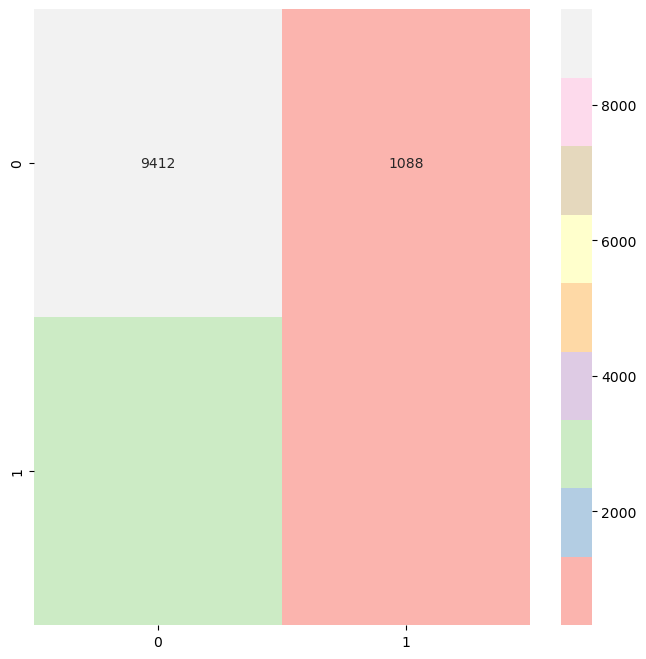

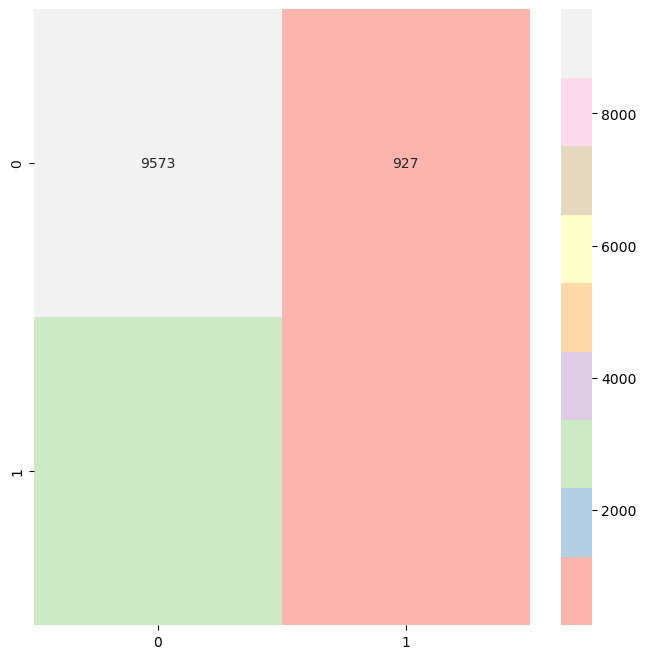

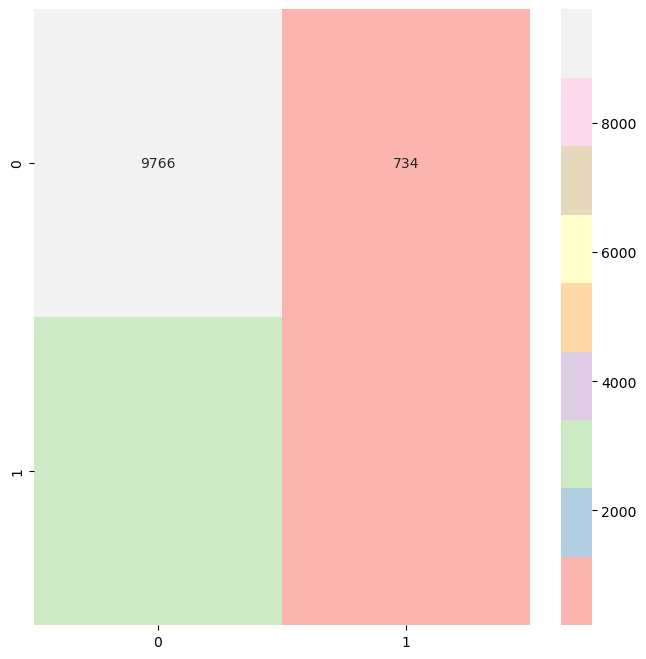

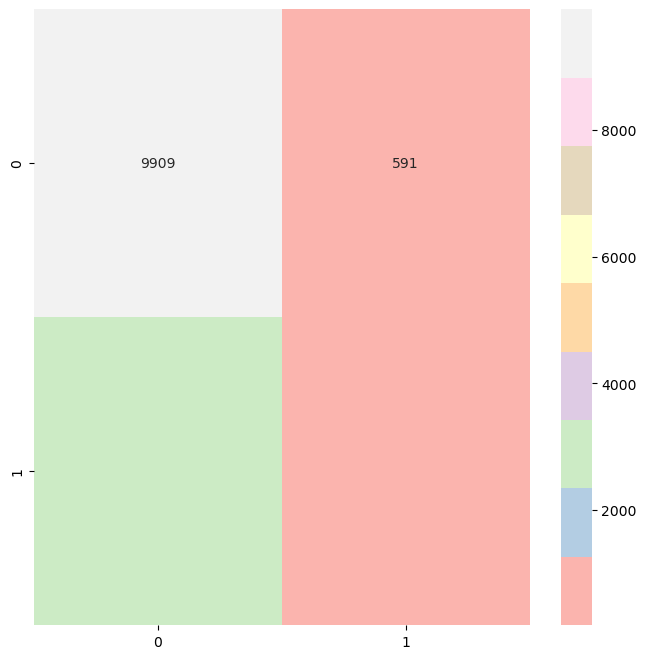

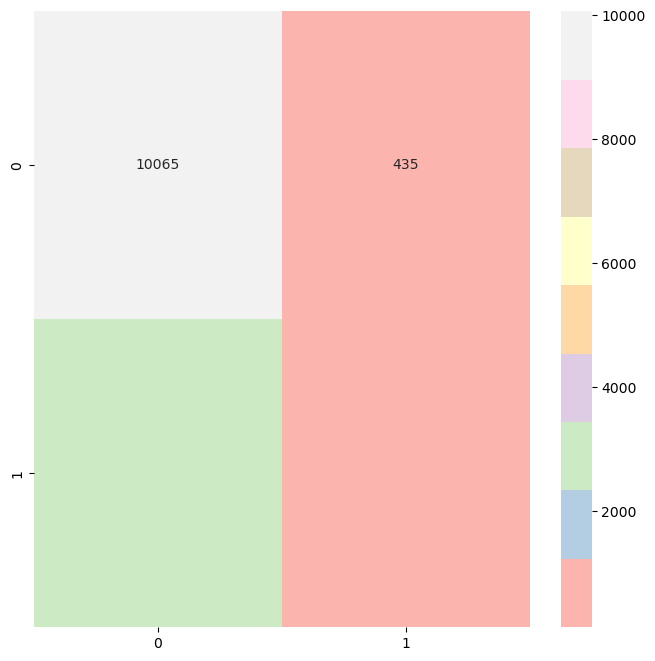

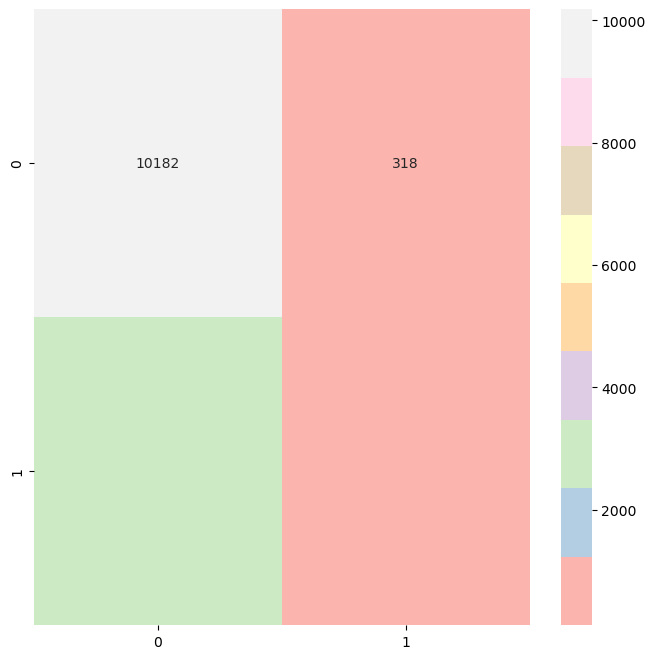

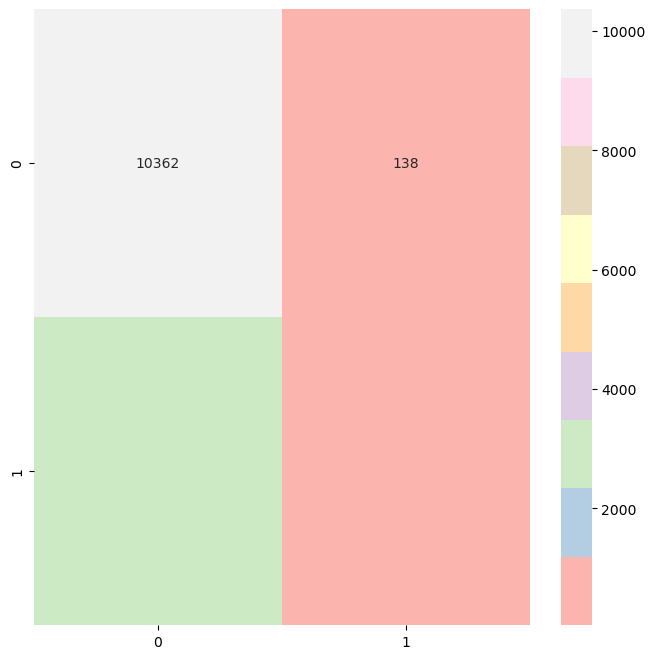

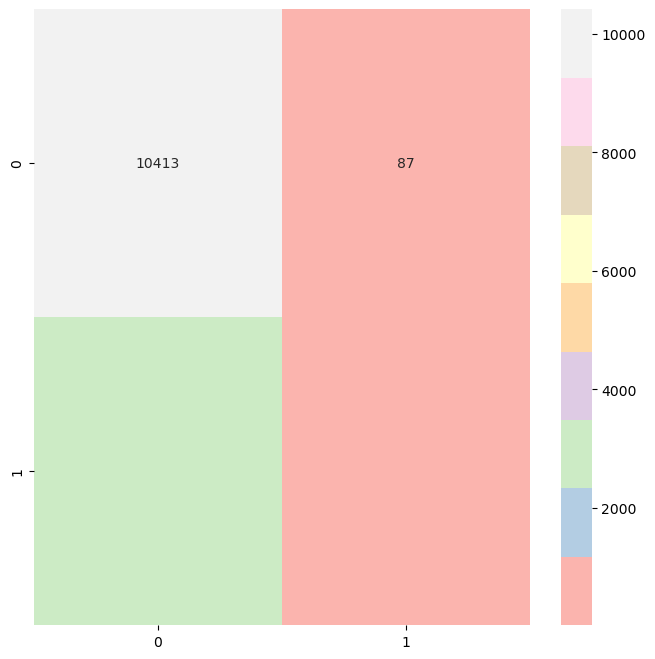

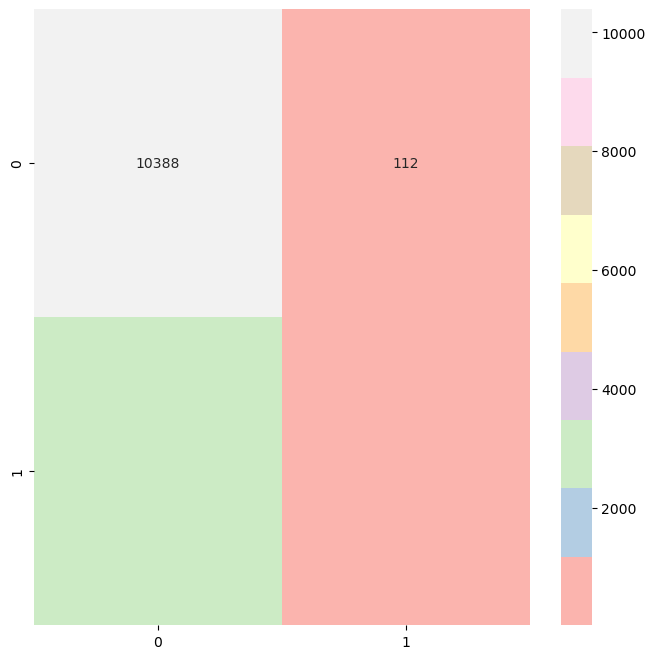

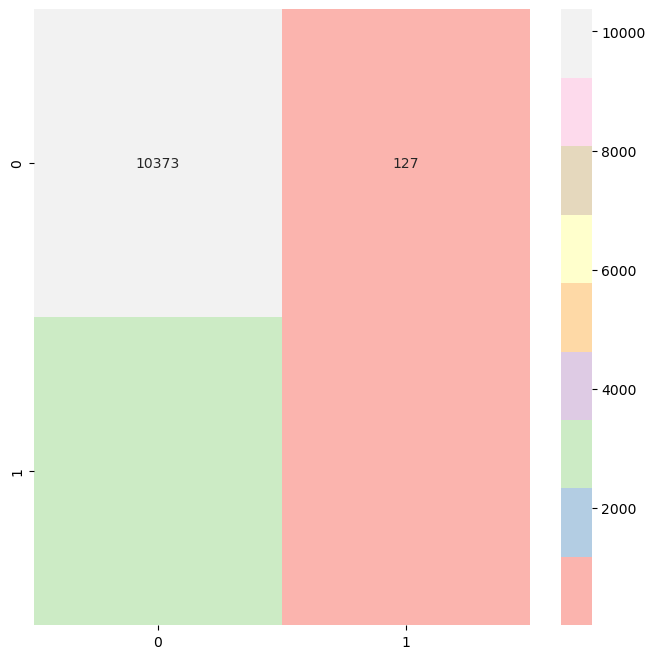

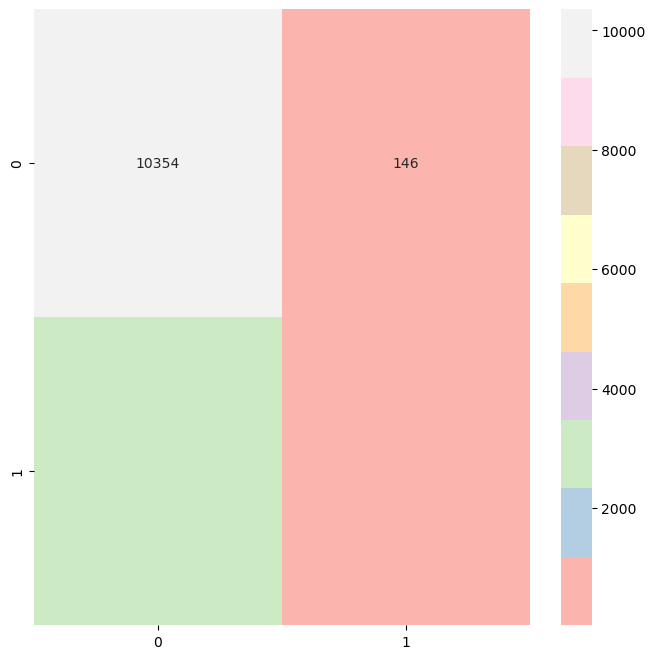

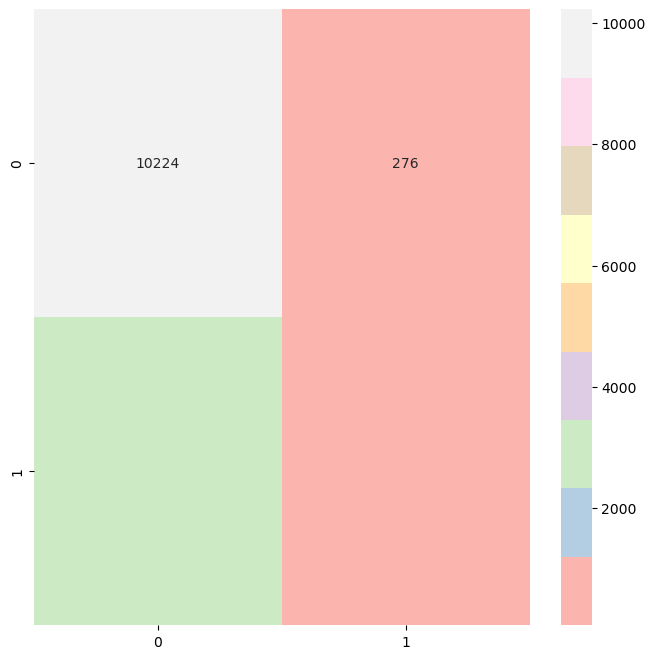

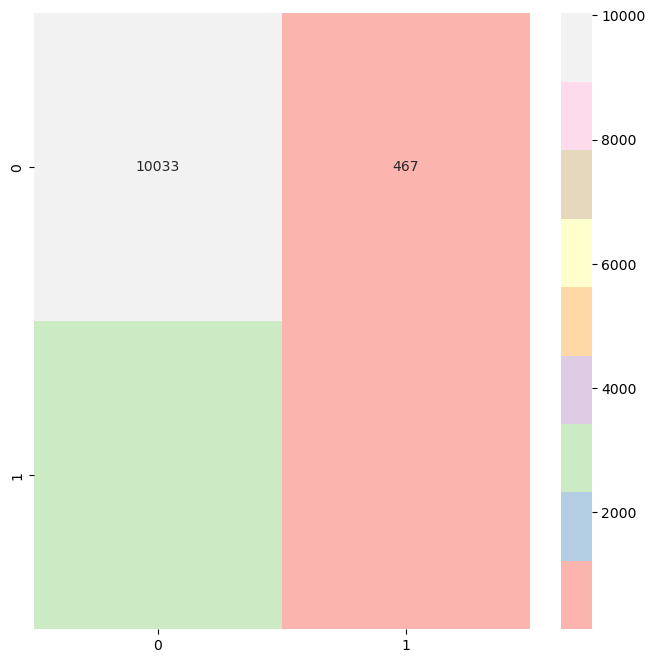

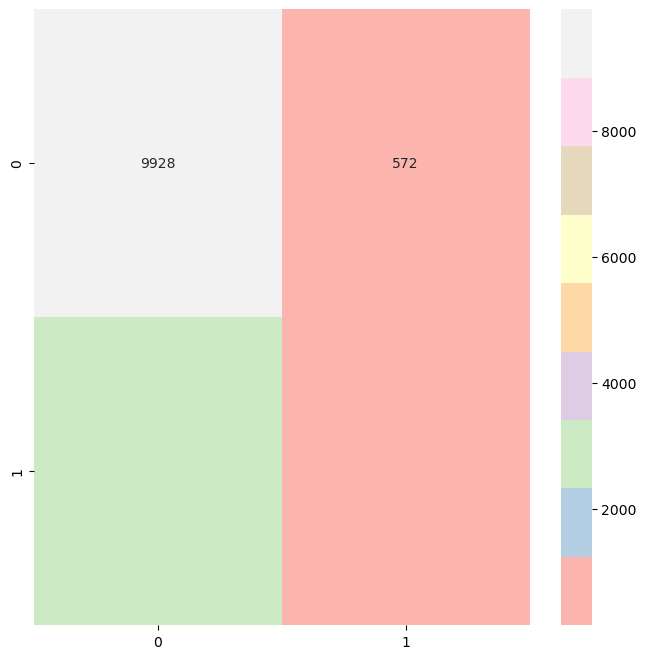

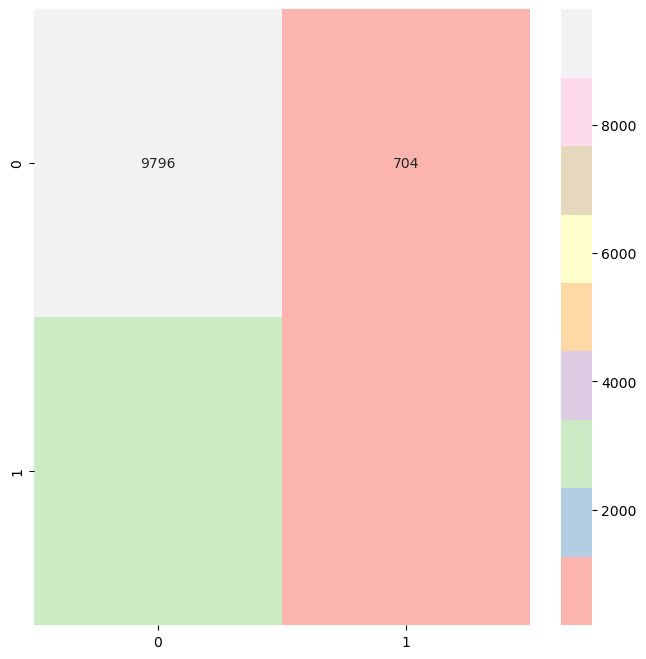

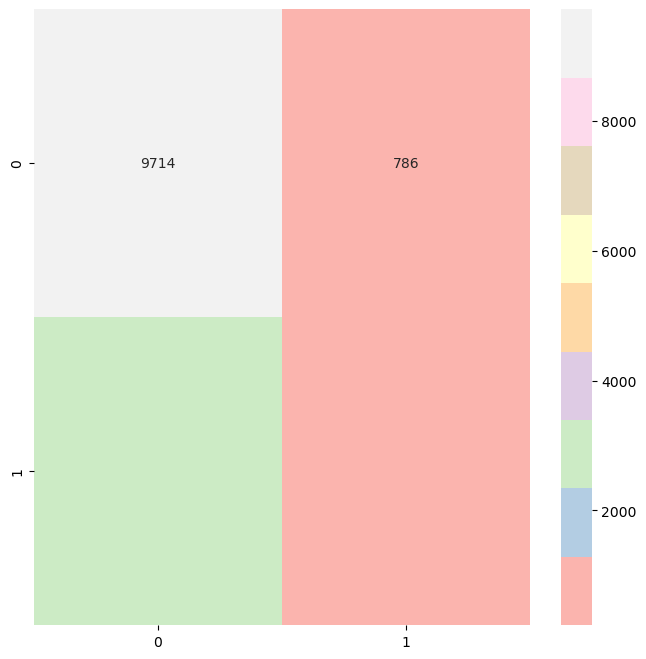

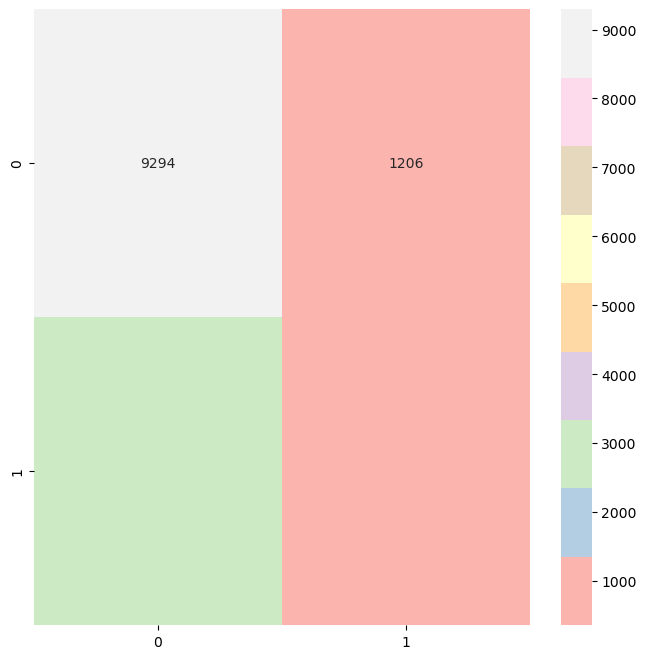

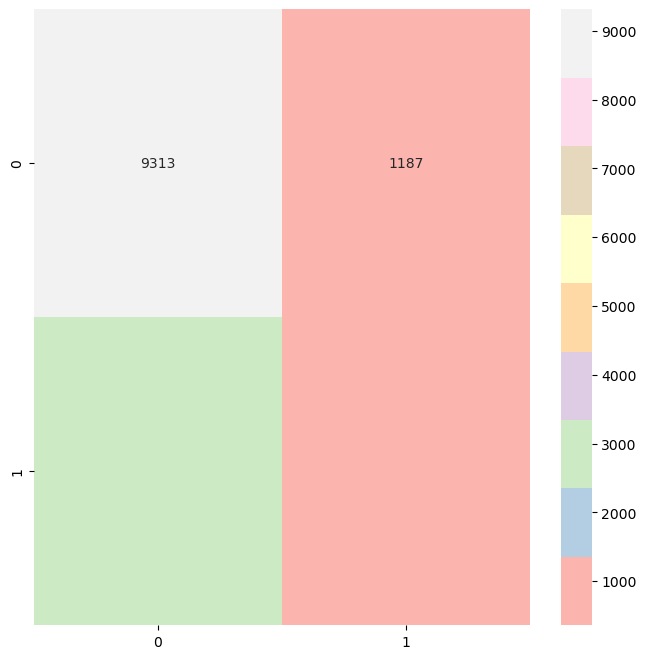

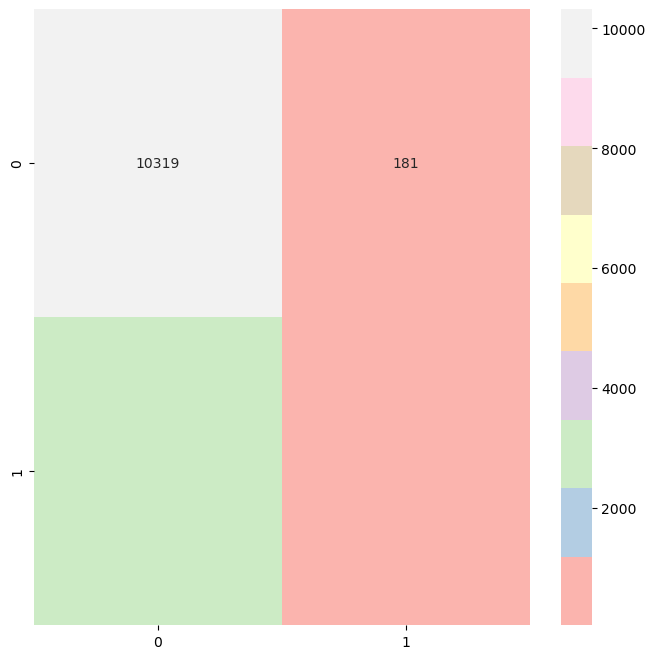

In [49]:
import time

def run_LOF_k(name, k):
    result=[]
    data = name
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        
    lof = LOF(X_train, X_test, k)
    lof = np.array(lof)
    pred = np.where(lof>=1.5,1,0)
    
    performance = return_result(y_test, pred)
    
    cf_vis(y_test, pred)

    for score, v in performance.items():
        print(score, ':', v)


    # 성능 값 저장
    result.append(performance['acc'])
    result.append(performance['precision_score'])
    result.append(performance['recall_score'])
    result.append(performance['f1_score'])

    return result

k_list = [1,2,3,4,5,10,20,30,40,50,100,200,300,400,500,1000,2000,3000,4000,5000,10000,20000,30000]
time_list=[]
acc_list=[]
pre_list=[]
rec_list=[]
f1_list=[]


for k in k_list: 
  start_time = time.time()  # start

  print(f'[k={k}]')
  result = run_LOF_k(data, k)
  end_time = time.time()  # end

  elapsed_time = end_time - start_time
  time_list.append(elapsed_time)
  acc_list.append(result[0])
  pre_list.append(result[1])
  rec_list.append(result[2])
  f1_list.append(result[3])

  print(f"실행 시간: {elapsed_time:.5f}초")
  print('-'*20)







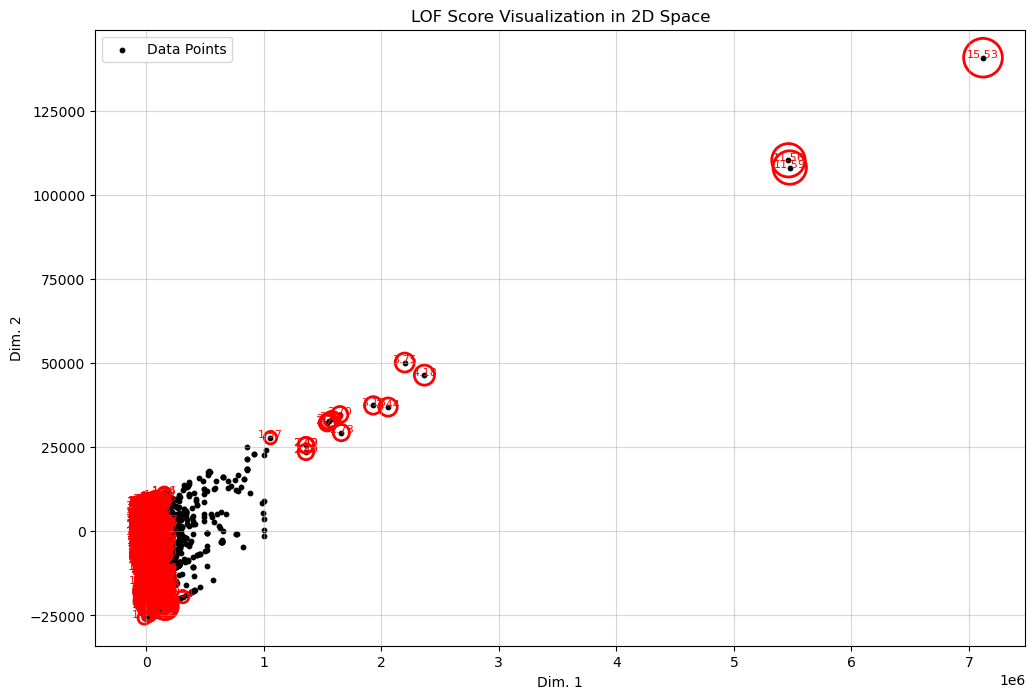

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor

# LOF 계산
lof_model = LocalOutlierFactor(n_neighbors=20)
lof_scores = -lof_model.fit_predict(data)
lof_factors = -lof_model.negative_outlier_factor_

# 차원 축소 (PCA 사용, 2D로 축소)
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)

# 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    data_2d[:, 0], data_2d[:, 1],
    c='black', s=10, label='Data Points'
)

# 이상치 강조
for i, (x, y) in enumerate(data_2d):
    if lof_factors[i] > 1.5:  # Threshold: LOF > 1.5
        plt.scatter(x, y, s=50 * lof_factors[i], edgecolor='red', facecolor='none', linewidth=2)
        plt.text(x, y, f"{lof_factors[i]:.2f}", fontsize=8, color='red', ha='center')

# 레이블 추가
plt.title("LOF Score Visualization in 2D Space")
plt.xlabel("Dim. 1")
plt.ylabel("Dim. 2")
plt.grid(alpha=0.5)
plt.legend()
plt.show()


#### 3-2. LOF with GridSearch

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best params: {'n_neighbors': 1, 'p': 1}
acc : 0.6433333333333333
precision_score : 0.5085852456937929
recall_score : 0.5094047619047619
f1_score : 0.5082808931923162


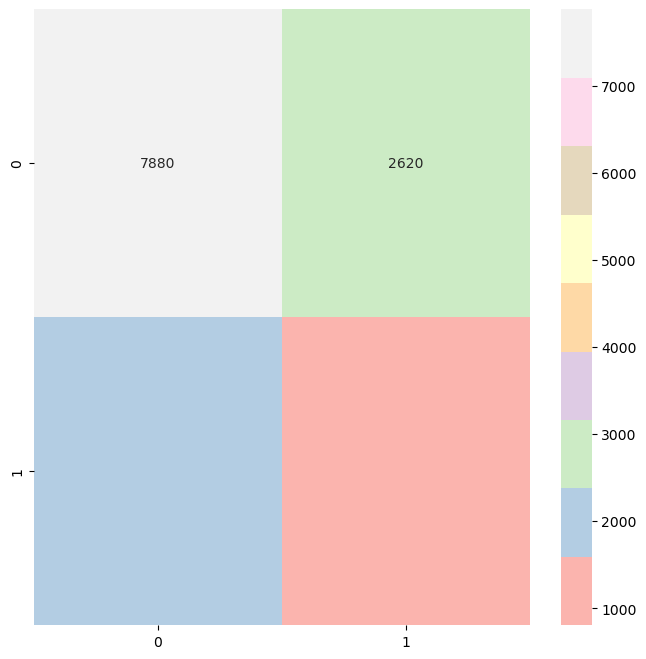

In [19]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV

def LOF_Search(name):
    data = name
    
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    model = LocalOutlierFactor()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    

    param_grid = {'n_neighbors': list(range(1, 31)), 
                        'p': [1, 2]}
        
    grid_search = GridSearchCV(model,param_grid,scoring="accuracy", refit=True,cv=10, return_train_score=True, verbose=1)

    grid_search.fit(X_train, y_train)
        
    best_params = grid_search.best_params_
    print(f"Best params: {best_params}")
        
    if_clf = LocalOutlierFactor(**best_params)
    if_clf.fit(X_train, y_train)

    y_pred = if_clf.fit_predict(X_test)
    pred = np.where(y_pred<=-1,1,0)
    
    performance = return_result(y_test, pred)
    
    cf_vis(y_test, pred)

    for k, v in performance.items():
        print(k, ':', v)

LOF_Search(data)